In [1]:
import os
import shutil
import pandas as pd
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:

image_path1 = 'Dataset/HAM10000_images_part_1'
image_path2 = 'Dataset/HAM10000_images_part_2'

final_image_dataset = 'Datset/skin-cancer-mnist-ham10000_combined'

os.makedirs(final_image_dataset, exist_ok=True)
def copy_images(source_path, destination_path):
    for filename in os.listdir(source_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            shutil.copy(os.path.join(source_path, filename), destination_path)

copy_images(image_path1, final_image_dataset)
copy_images(image_path2, final_image_dataset)

metadata_path = 'Datset/HAM10000_metadata.csv'
meta_data = pd.read_csv(metadata_path)


meta_data['Image_path'] = meta_data['image_id'].apply(lambda x: os.path.join(final_image_dataset, f"{x}.jpg").replace("\\", "/"))



le = LabelEncoder()
meta_data['label'] = le.fit_transform(meta_data["dx"])


meta_data['label'] = meta_data['label'].astype(str)

df_shuffled=meta_data.sample(frac=1,random_state=42).reset_index(drop=True)

train_df, test_df = train_test_split(df_shuffled, test_size=0.3, stratify=df_shuffled["dx"], random_state=42)


train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df["dx"], random_state=42)


train_df["dx"].value_counts()

   

dx
nv       3755
mel       623
bkl       615
bcc       288
akiec     183
vasc       79
df         65
Name: count, dtype: int64

In [3]:
train_df['Image_path'][0] == 'Dataset/skin-cancer-mnist-ham10000_combined/ISIC_0033272.jpg'

True

In [4]:
n_samples = 3755  # Maximum count of the 'nv' class

    # Separate each class
df_nv = train_df[train_df['dx'] == 'nv']
df_mel = train_df[train_df['dx'] == 'mel']
df_bkl = train_df[train_df['dx'] == 'bkl']
df_bcc = train_df[train_df['dx'] == 'bcc']
df_akiec = train_df[train_df['dx'] == 'akiec']
df_vasc =train_df[train_df['dx'] == 'vasc']
df_df =train_df[train_df['dx'] == 'df']

    # Balance the classes
df_nv_balanced = resample(df_nv, replace=False, n_samples=n_samples, random_state=42)
df_mel_balanced = resample(df_mel, replace=True, n_samples=n_samples, random_state=42)
df_bkl_balanced = resample(df_bkl, replace=True, n_samples=n_samples, random_state=42)
df_bcc_balanced = resample(df_bcc, replace=True, n_samples=n_samples, random_state=42)
df_akiec_balanced = resample(df_akiec, replace=True, n_samples=n_samples, random_state=42)
df_vasc_balanced = resample(df_vasc, replace=True, n_samples=n_samples, random_state=42)
df_df_balanced = resample(df_df, replace=True, n_samples=n_samples, random_state=42)

    # Combine the resampled datasets
balanced_train_df = pd.concat([df_nv_balanced, df_mel_balanced, df_bkl_balanced,
                                df_bcc_balanced, df_akiec_balanced, df_vasc_balanced,
                                df_df_balanced])
    
    # Shuffle the combined dataset
balanced_train_df = balanced_train_df.sample(frac=1, random_state=42).reset_index(drop=True)

#     print(f"Balanced dataset class distribution:\n{balanced_meta_data['dx'].value_counts()}")

print(f"Training set size: {balanced_train_df['dx'].value_counts()}")
print(f"Validation set size: {val_df['dx'].value_counts()}")
    
print(f"Testing set size: {test_df['dx'].value_counts()}")



def preprocess_images(df, image_size):
    images = []
    labels = []
    for i, row in df.iterrows():
        img = load_img(row['Image_path'], target_size=image_size)
        img = img_to_array(img) / 255.0  # Rescale the image
        images.append(img)
        labels.append(int(row['label']))
    return np.array(images), np.array(labels)

# Resize images to 32x32
image_size = (32, 32)
X_train, y_train = preprocess_images(train_df, image_size)
X_val, y_val = preprocess_images(val_df, image_size)
X_test, y_test = preprocess_images(test_df, image_size)

Training set size: dx
akiec    3755
df       3755
nv       3755
bkl      3755
mel      3755
vasc     3755
bcc      3755
Name: count, dtype: int64
Validation set size: dx
nv       938
mel      156
bkl      154
bcc       72
akiec     46
vasc      20
df        16
Name: count, dtype: int64
Testing set size: dx
nv       2012
mel       334
bkl       330
bcc       154
akiec      98
vasc       43
df         34
Name: count, dtype: int64


In [6]:
balanced_train_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,Image_path,label
0,HAM_0000931,ISIC_0028820,akiec,histo,80.0,male,lower extremity,skin-cancer-mnist-ham10000_combined/ISIC_00288...,0
1,HAM_0007227,ISIC_0029891,df,histo,75.0,male,lower extremity,skin-cancer-mnist-ham10000_combined/ISIC_00298...,3
2,HAM_0004226,ISIC_0032494,nv,histo,25.0,female,trunk,skin-cancer-mnist-ham10000_combined/ISIC_00324...,5
3,HAM_0006938,ISIC_0033613,bkl,histo,45.0,male,face,skin-cancer-mnist-ham10000_combined/ISIC_00336...,2
4,HAM_0002182,ISIC_0030539,mel,histo,65.0,female,face,skin-cancer-mnist-ham10000_combined/ISIC_00305...,4


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2
model = Sequential()
model.add(Conv2D(128, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.0005)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0005)))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 256)       5

In [9]:
# Compile the model
optimizer = Adam(learning_rate=1e-4)  # Slightly lower learning rate for better convergence
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=7)
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes=7)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=7)
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

In [10]:
y_val_cat.shape

(1402, 7)

In [11]:
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=50,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
176/176 [==============================] - 68s 382ms/step - loss: 1.5574 - accuracy: 0.5580 - val_loss: 1.8172 - val_accuracy: 0.4793 - lr: 1.0000e-04
Epoch 2/50
176/176 [==============================] - 65s 368ms/step - loss: 1.2563 - accuracy: 0.6500 - val_loss: 2.1015 - val_accuracy: 0.1098 - lr: 1.0000e-04
Epoch 3/50
176/176 [==============================] - 78s 443ms/step - loss: 1.1723 - accuracy: 0.6772 - val_loss: 1.3650 - val_accuracy: 0.5656 - lr: 1.0000e-04
Epoch 4/50
176/176 [==============================] - 65s 367ms/step - loss: 1.1259 - accuracy: 0.6842 - val_loss: 1.1807 - val_accuracy: 0.6748 - lr: 1.0000e-04
Epoch 5/50
176/176 [==============================] - 61s 344ms/step - loss: 1.0903 - accuracy: 0.6965 - val_loss: 1.1958 - val_accuracy: 0.6612 - lr: 1.0000e-04
Epoch 6/50
176/176 [==============================] - 62s 351ms/step - loss: 1.0582 - accuracy: 0.7033 - val_loss: 1.2552 - val_accuracy: 0.6812 - lr: 1.0000e-04
Epoch 7/50
176/176 [========

In [13]:
import matplotlib.pyplot as plt
# Evaluate test accuracy
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")

94/94 [==============================] - 10s 106ms/step - loss: 0.9214 - accuracy: 0.7634
Test Accuracy: 0.7634


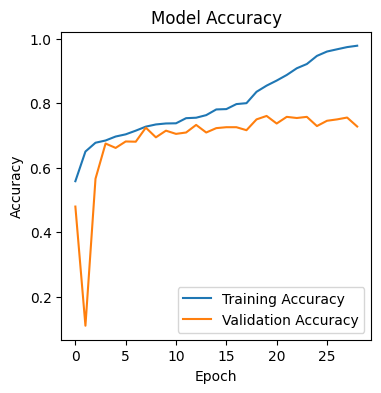

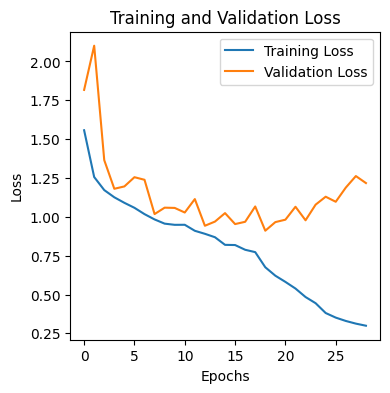

In [14]:
# Plot training & validation accuracy
plt.figure(figsize=(4, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()
# Plotting Training & Validation Loss
plt.figure(figsize=(4, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [18]:
def preprocess_image(img_path):
    # Read the image using OpenCV
    img = cv2.imread(img_path)
    # Resize the image to 32x32 pixels
    img = cv2.resize(img, (32, 32))
    # Convert BGR (default for OpenCV) to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Normalize the image (assuming the model was trained on normalized images)
    img = img / 255.0
    # Add batch dimension
    img = np.reshape(img, (1, 32, 32, 3))
    return img

In [21]:
def predict_image(img_path, model):

    img_data = preprocess_image(img_path)

    predictions = model.predict(img_data)
    
    predicted_class = np.argmax(predictions, axis=1)[0]
    
    predicted_probability = np.max(predictions, axis=1)[0]
    
    print(f"Predicted class: {predicted_class} with probability: {predicted_probability:.4f}")

    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(f'Predicted Class: {predicted_class}, Probability: {predicted_probability:.4f}')
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 26ms/step
Predicted class: 1 with probability: 0.4811


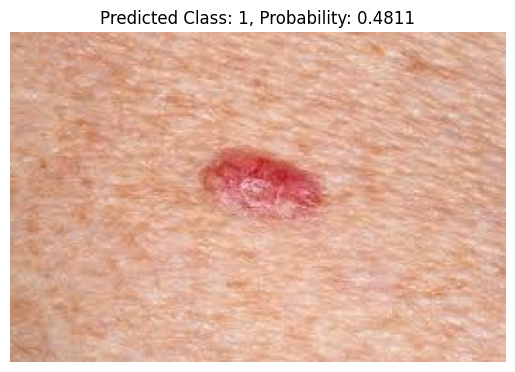

In [30]:
img_path = "Resources/1.jpeg"
predict_image(img_path, model)

1/1 [==============================] - 0s 24ms/step
Predicted class: 5 with probability: 0.7596


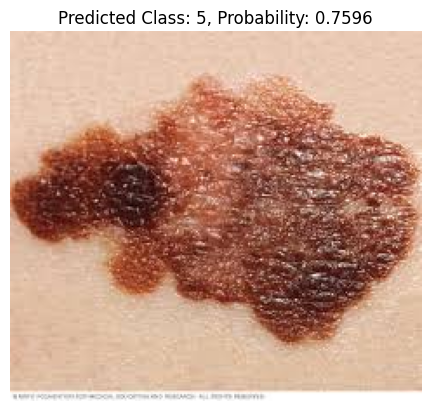

In [31]:
img_path = "Resources/5.jpeg"
predict_image(img_path, model)

In [26]:
model.save("Resources/model.h5")